# Time Series Analysis for Guayas Region  - XGBoost Model

## 1.Import Libraries

In [1]:
import pandas as pd # data manupulation
import numpy as np # numeric operations
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import os
from pathlib import Path
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
from darts import TimeSeries
from darts.models import AutoARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 

import pickle


/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.Config and Loading DataFrames

### 1.Set Data Path

In [2]:
# Define Data Path
DATA_PATH = Path("/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting")

### 2.Data Loading

In [3]:
#Load all supporting CSV files except train.csv.
df_items = pd.read_csv(DATA_PATH / "items.csv")
df_stores = pd.read_csv(DATA_PATH / "stores.csv")
df_oil = pd.read_csv(DATA_PATH / "oil.csv")
df_holidays_events = pd.read_csv(DATA_PATH / "holidays_events.csv")
df_transactions = pd.read_csv(DATA_PATH / "transactions.csv")

In [4]:
# Load prepared DataFram from week1 called guayas_dataset
df_train = pd.read_csv(DATA_PATH / 'full_guayas_dataset.csv')

### 3.Filtering DataFrame by spedified date range

In [5]:
# Filter DataFrame by date range
min_date = '2014-01-01'
max_date = '2014-04-01'

df_train= df_train[
    (df_train['date'] >= min_date) &
    (df_train['date'] < max_date)
]

## 3. Data Preperation

In [6]:
df_train.head(10)



,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,holiday_type,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
357,2014-01-01,0,24,96995,0.0,0,2014,1,1,2,...,0.0,0.0,Holiday,True,NaN,96.655,98.677143,GROCERY I,1093,False
358,2014-01-02,16352778,24,96995,3.0,0,2014,1,2,3,...,0.0,1.0,NaN,False,inf,95.140,98.144286,GROCERY I,1093,False
359,2014-01-03,16418869,24,96995,2.0,0,2014,1,3,4,...,0.0,0.0,NaN,False,inf,93.660,97.377857,GROCERY I,1093,False
360,2014-01-04,0,24,96995,0.0,0,2014,1,4,5,...,3.0,0.0,NaN,False,-1.000000,NaN,NaN,GROCERY I,1093,False
361,2014-01-05,0,24,96995,0.0,0,2014,1,5,6,...,0.0,0.0,NaN,False,NaN,NaN,NaN,GROCERY I,1093,False
362,2014-01-06,0,24,96995,0.0,0,2014,1,6,0,...,5.0,0.0,NaN,False,-1.000000,93.120,96.512143,GROCERY I,1093,False
363,2014-01-07,16682272,24,96995,1.0,0,2014,1,7,1,...,5.0,2.0,NaN,False,-0.800000,93.310,95.565000,GROCERY I,1093,False
364,2014-01-08,0,24,96995,0.0,0,2014,1,8,2,...,0.0,0.0,NaN,False,NaN,91.900,94.565000,GROCERY I,1093,False
365,2014-01-09,16808029,24,96995,1.0,0,2014,1,9,3,...,3.0,0.0,NaN,False,-0.666667,91.360,93.592143,GROCERY I,1093,False
366,2014-01-10,0,24,96995,0.0,0,2014,1,10,4,...,2.0,1.0,NaN,False,-1.000000,92.390,92.982857,GROCERY I,1093,False


### 1. Handling Boolean Values

In [7]:
df_train['is_holiday'].unique().sum()

np.int64(1)

In [8]:
# Change from boolean to binary
df_train['is_holiday'] = df_train['is_holiday'].apply(lambda x: 1 if x == True else 0)

### 2. Drop 'holiday_type' because information already exists 

In [9]:
# Does it make sense to keep these Column?
df_train['holiday_type'].unique()

array(['Holiday', nan], dtype=object)

In [10]:
# Decided to drop the 'holiday_type' column, because the needed informatio already exists in the column 'is_holiday'
df_train = df_train.drop(columns=['holiday_type'])

In [11]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
357,2014-01-01,0,24,96995,0.0,0,2014,1,1,2,...,5.0,0.0,0.0,1,NaN,96.655,98.677143,GROCERY I,1093,False
358,2014-01-02,16352778,24,96995,3.0,0,2014,1,2,3,...,0.0,0.0,1.0,0,inf,95.140,98.144286,GROCERY I,1093,False
359,2014-01-03,16418869,24,96995,2.0,0,2014,1,3,4,...,3.0,0.0,0.0,0,inf,93.660,97.377857,GROCERY I,1093,False
360,2014-01-04,0,24,96995,0.0,0,2014,1,4,5,...,2.0,3.0,0.0,0,-1.0,NaN,NaN,GROCERY I,1093,False
361,2014-01-05,0,24,96995,0.0,0,2014,1,5,6,...,0.0,0.0,0.0,0,NaN,NaN,NaN,GROCERY I,1093,False


In [12]:
df_train['is_weekend'] = df_train['is_weekend'].apply(lambda x: 1 if x == True else 0)

### 3. Drop 'perishable' column due to the fact all items have the same value

In [13]:
df_train['perishable'].unique()

array([False])

In [14]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
357,2014-01-01,0,24,96995,0.0,0,2014,1,1,2,...,5.0,0.0,0.0,1,NaN,96.655,98.677143,GROCERY I,1093,False
358,2014-01-02,16352778,24,96995,3.0,0,2014,1,2,3,...,0.0,0.0,1.0,0,inf,95.140,98.144286,GROCERY I,1093,False
359,2014-01-03,16418869,24,96995,2.0,0,2014,1,3,4,...,3.0,0.0,0.0,0,inf,93.660,97.377857,GROCERY I,1093,False
360,2014-01-04,0,24,96995,0.0,0,2014,1,4,5,...,2.0,3.0,0.0,0,-1.0,NaN,NaN,GROCERY I,1093,False
361,2014-01-05,0,24,96995,0.0,0,2014,1,5,6,...,0.0,0.0,0.0,0,NaN,NaN,NaN,GROCERY I,1093,False


In [15]:
# drop colum 'perishable' because every item is not perishable
df_train = df_train.drop(columns=['perishable'])

### 4. Create additional Features for rolling standard deviation and a rolling maximum

In [16]:
# New feature for rolling 7 days standard deviation 
df_train['rolling_std_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).std())

# New feature for rolling 7 days maximum sales
df_train['rolling_max_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).max())


### 4.Handling Nas Values 

In [17]:
df_train.isna().sum()

date                    0
id                      0
store_nbr               0
item_nbr                0
unit_sales              0
onpromotion             0
year                    0
month                   0
day                     0
day_of_week             0
is_weekend              0
rolling_mean_7       9929
lag_1                1656
lag_7               11583
lag_30              49543
is_holiday              0
sales_change_7d    262816
dcoilwtico         293419
rolling_oil_7d     293419
family                  0
class                   0
rolling_std_7       68650
rolling_max_7       68650
dtype: int64

In [18]:
# fill Rolling mean, std and max with appropriate values
df_train['rolling_mean_7'] = df_train['rolling_mean_7'].fillna(0)
df_train['rolling_std_7'] = df_train['rolling_std_7'].fillna(0)
df_train['rolling_max_7'] = df_train['rolling_max_7'].fillna(0)

# fill lag features with appropriate values
df_train['lag_1'] = df_train['lag_1'].fillna(0)
df_train['lag_7'] = df_train['lag_7'].fillna(0)
df_train['lag_30'] = df_train['lag_30'].fillna(0)

In [19]:
# Sales change - fill with 0 (no change)
df_train['sales_change_7d'] = df_train['sales_change_7d'].fillna(0)

In [20]:
# Oil prices - forward fill then backward fill
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')

/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_5574/87206519.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_5574/87206519.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')


In [21]:
# Replace inf with 0 'sales_change_7d'
df_train['sales_change_7d'] = df_train['sales_change_7d'].replace([np.inf, -np.inf], 0)

### 4.Change DType of Date

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013765 entries, 357 to 23143429
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1013765 non-null  object 
 1   id               1013765 non-null  int64  
 2   store_nbr        1013765 non-null  int64  
 3   item_nbr         1013765 non-null  int64  
 4   unit_sales       1013765 non-null  float64
 5   onpromotion      1013765 non-null  int64  
 6   year             1013765 non-null  int64  
 7   month            1013765 non-null  int64  
 8   day              1013765 non-null  int64  
 9   day_of_week      1013765 non-null  int64  
 10  is_weekend       1013765 non-null  int64  
 11  rolling_mean_7   1013765 non-null  float64
 12  lag_1            1013765 non-null  float64
 13  lag_7            1013765 non-null  float64
 14  lag_30           1013765 non-null  float64
 15  is_holiday       1013765 non-null  int64  
 16  sales_change_7d  101

In [23]:
# Convert date column to DateTime
df_train['date'] = pd.to_datetime(df_train['date'])

In [24]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,rolling_std_7,rolling_max_7
357,2014-01-01,0,24,96995,0.0,0,2014,1,1,2,...,0.0,0.0,1,0.0,96.655,98.677143,GROCERY I,1093,0.0,0.0
358,2014-01-02,16352778,24,96995,3.0,0,2014,1,2,3,...,0.0,1.0,0,0.0,95.140,98.144286,GROCERY I,1093,0.0,0.0
359,2014-01-03,16418869,24,96995,2.0,0,2014,1,3,4,...,0.0,0.0,0,0.0,93.660,97.377857,GROCERY I,1093,0.0,0.0
360,2014-01-04,0,24,96995,0.0,0,2014,1,4,5,...,3.0,0.0,0,-1.0,93.660,97.377857,GROCERY I,1093,0.0,0.0
361,2014-01-05,0,24,96995,0.0,0,2014,1,5,6,...,0.0,0.0,0,0.0,93.660,97.377857,GROCERY I,1093,0.0,0.0


## 4. XGBoost Model 

In [25]:
df_boost = df_train[['date','store_nbr','item_nbr','id','unit_sales','lag_1','lag_7','lag_30','rolling_mean_7','sales_change_7d','dcoilwtico','day','month','year','is_weekend','rolling_std_7']]

### 2. Train-Test Split

In [26]:
split_date = '2014-02-28'
train = df_boost[df_boost['date'] < split_date]
test = df_boost[df_boost['date'] > split_date]

In [27]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

### 3. Train XGBoost Regressor Model 

In [28]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

### 4. Model Validation and Visualization of Predictions 

In [30]:
# Metrics for model valdation
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))

R2: 0.8921913022470208
MAE: 0.8322656585907332
RMSE: 3.8913960294298913


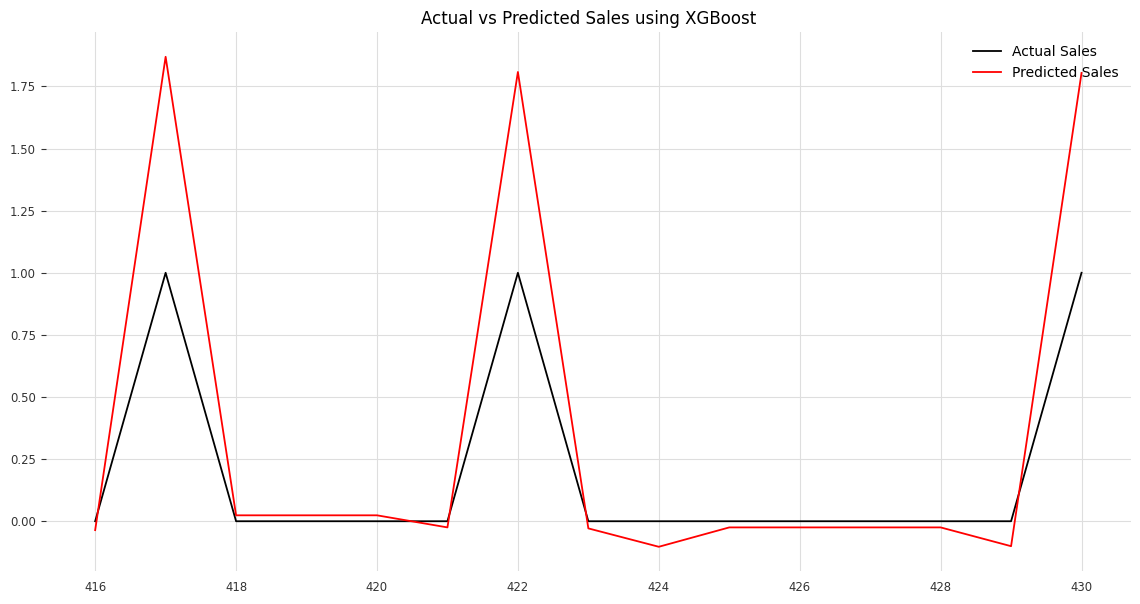

In [31]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

### 5. Hyperparameter Tuning

In [32]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'eta': 0.1, 'colsample_bytree': 1.0}


Best model:
 - eta = 0.7
 - n_estimator = 200
 - max_depth = 5
 - subsample = 0.7
 - colsample_bytree = 1.0



### 6. Train Model again with Best Estimators

In [33]:
best_model = random_search.best_estimator_

In [34]:
# Make predictions on the test set
y_pred_1 = best_model.predict(X_test)

In [35]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred_1))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred_1))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_1)))

R2: 0.8885957463500285
MAE: 0.9179370995201372
RMSE: 3.9557552950462354


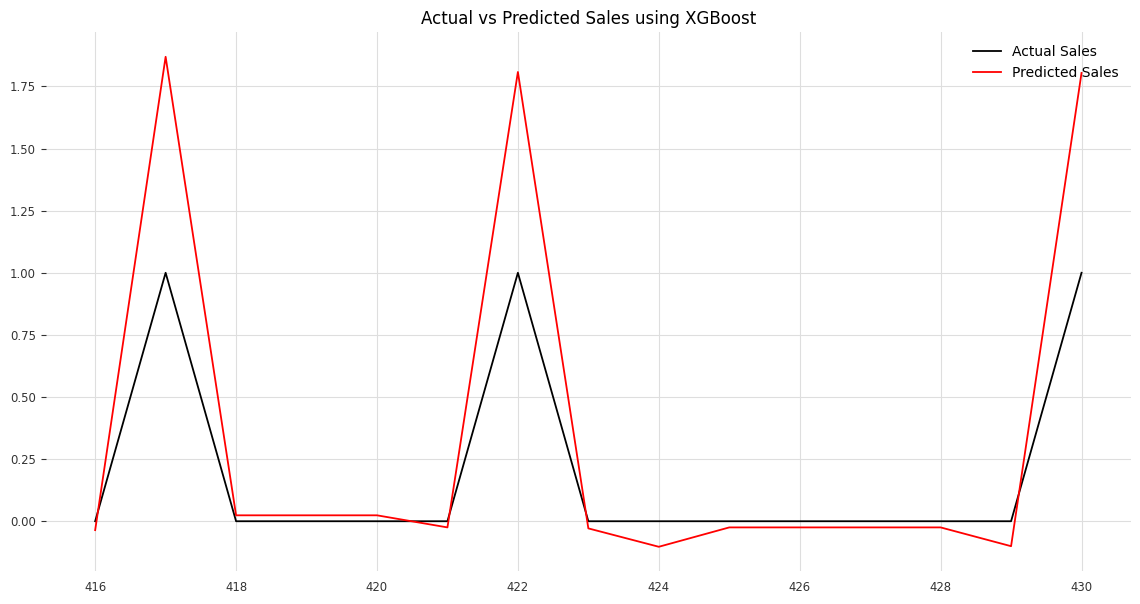

In [36]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

The hyperparameter-tuned model is superior, achieving better predictive accuracy with lower errors (MAE: 0.770 vs 0.832, RMSE: 4.194 vs 3.891) while maintaining strong explanatory power (R²: 0.875 vs 0.892).



### 7. Save Model as pickel file

In [37]:
# define path where model is going to save
pickle_path = '/Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting/best_model.pkl'

In [38]:
# saving best model
with open(pickle_path, 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_test': X_test, 'best_model': best_model}, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /Users/lukasfichtner/Documents/VS Code Workspace/favorita-grocery-sales-forecasting/best_model.pkl


## 5. Additional TimeSeries Analysis Models

### 1.Time Series Visualization

In [39]:
# Group by date and aggregate sales for each day
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

### 2. Plot Time Series


=== TIME SERIES VISUALIZATION ===


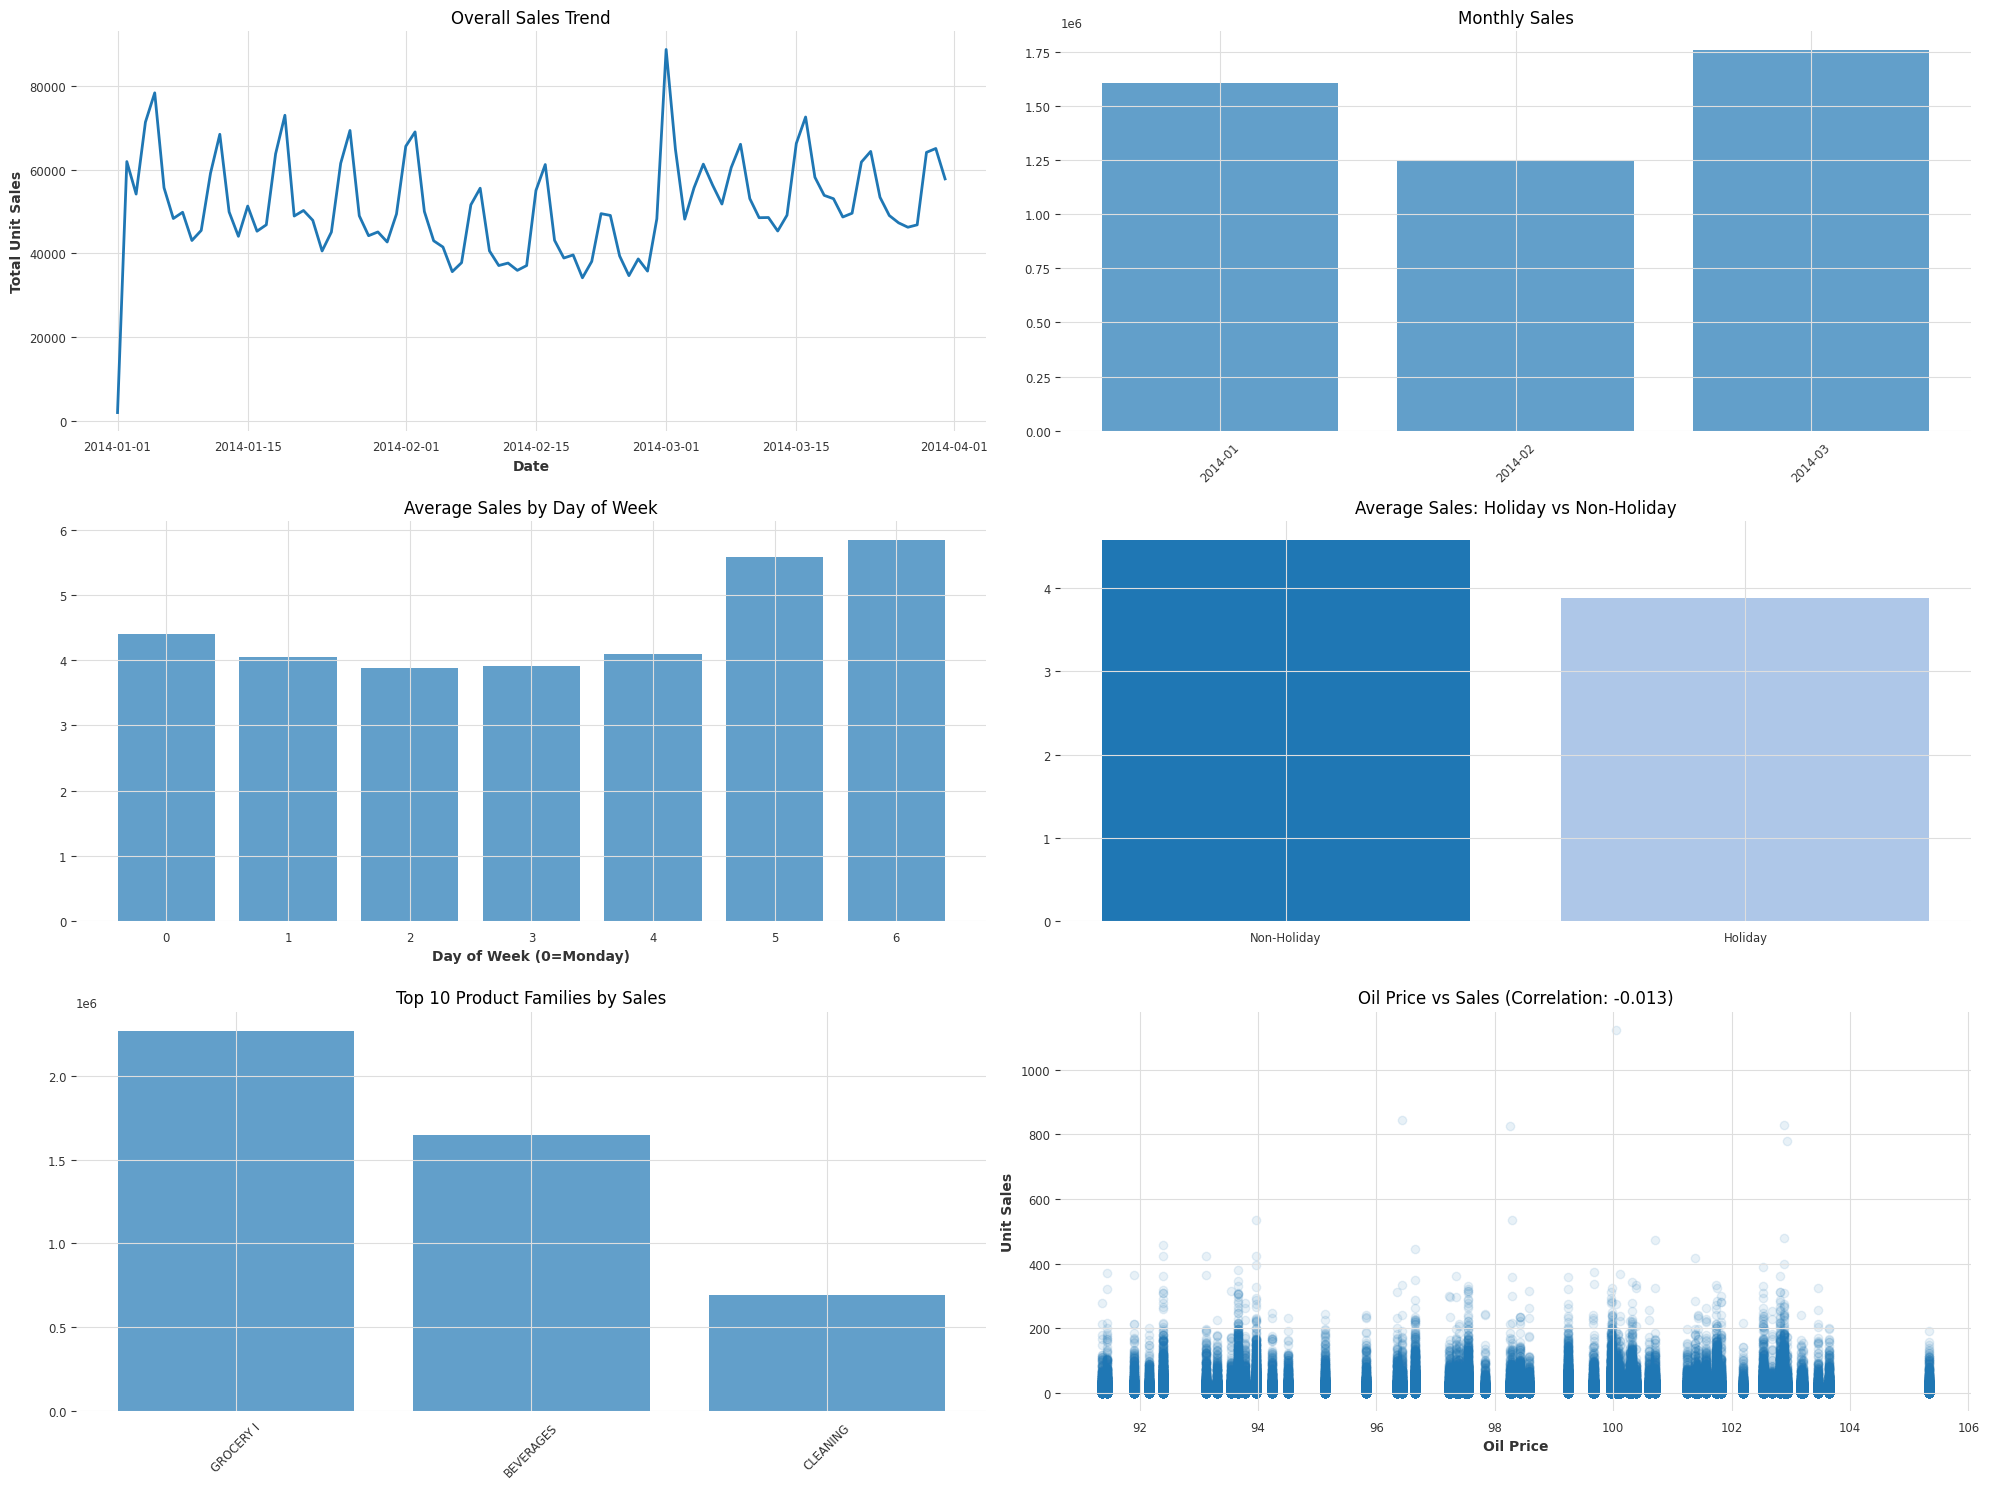

In [40]:
def plot_time_series(df):
    print("\n=== TIME SERIES VISUALIZATION ===")
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    # Set blue color for all plots
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue ='#aec7e8'  # Lighter blue for variety
    
    # Overall sales trend
    axes[0,0].plot(daily_sales['date'], daily_sales['unit_sales'], color=blue_color, linewidth=2)
    axes[0,0].set_title('Overall Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Total Unit Sales')
    
    # Monthly sales pattern
    monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
    monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)
    axes[0,1].bar(monthly_sales['year_month'], monthly_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[0,1].set_title('Monthly Sales')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Day of week pattern
    dow_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()
    axes[1,0].bar(dow_sales['day_of_week'], dow_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[1,0].set_title('Average Sales by Day of Week')
    axes[1,0].set_xlabel('Day of Week (0=Monday)')
    
    # Holiday vs non-holiday sales
    holiday_sales = df.groupby('is_holiday')['unit_sales'].mean().reset_index()
    axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales['unit_sales'], color=[blue_color, light_blue])
    axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')
    
    # Sales by family (top 10)
    family_sales = df.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(10)
    axes[2,0].bar(family_sales.index, family_sales.values, color=blue_color, alpha=0.7)
    axes[2,0].set_title('Top 10 Product Families by Sales')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Oil price vs sales correlation
    oil_corr = df[['unit_sales', 'dcoilwtico']].corr().iloc[0,1]
    axes[2,1].scatter(df['dcoilwtico'], df['unit_sales'], alpha=0.1, color=blue_color)
    axes[2,1].set_title(f'Oil Price vs Sales (Correlation: {oil_corr:.3f})')
    axes[2,1].set_xlabel('Oil Price')
    axes[2,1].set_ylabel('Unit Sales')
    
    plt.tight_layout()
    plt.show()

plot_time_series(df_train)

### 3. Time Series Decomposition and Stationarity


=== TIME SERIES DECOMPOSITION ===


/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_5574/3109925569.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('D').mean().fillna(method='ffill')


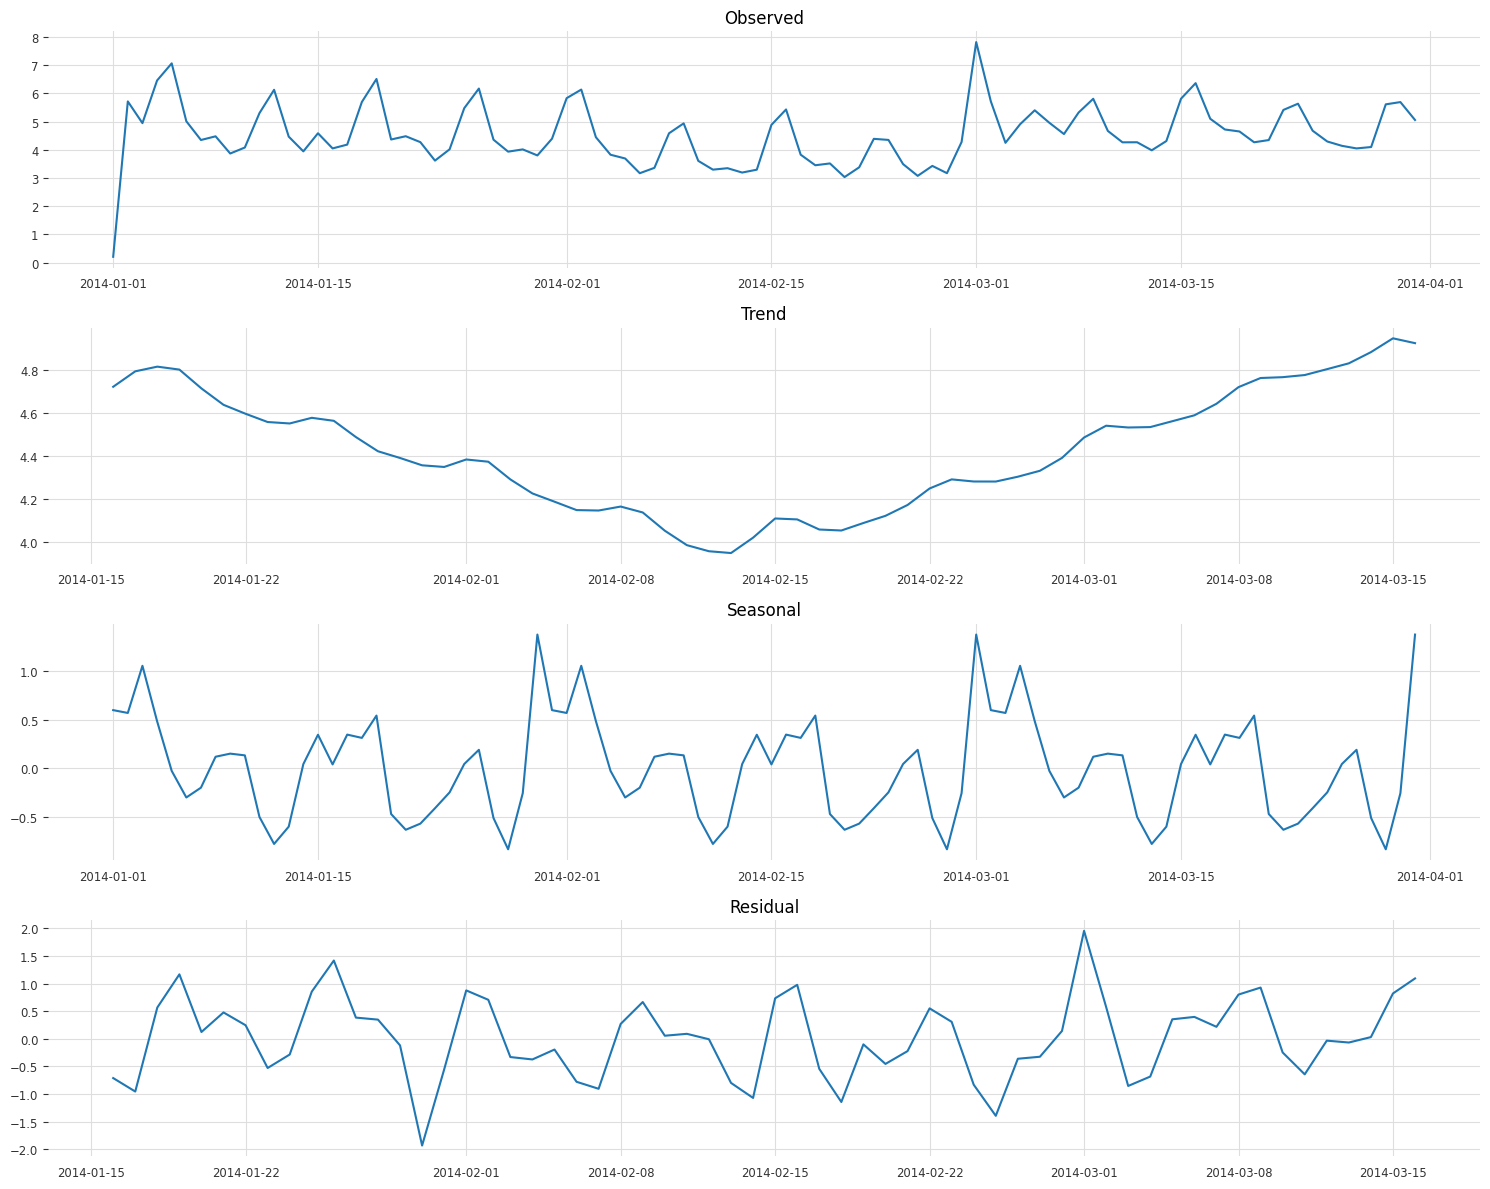

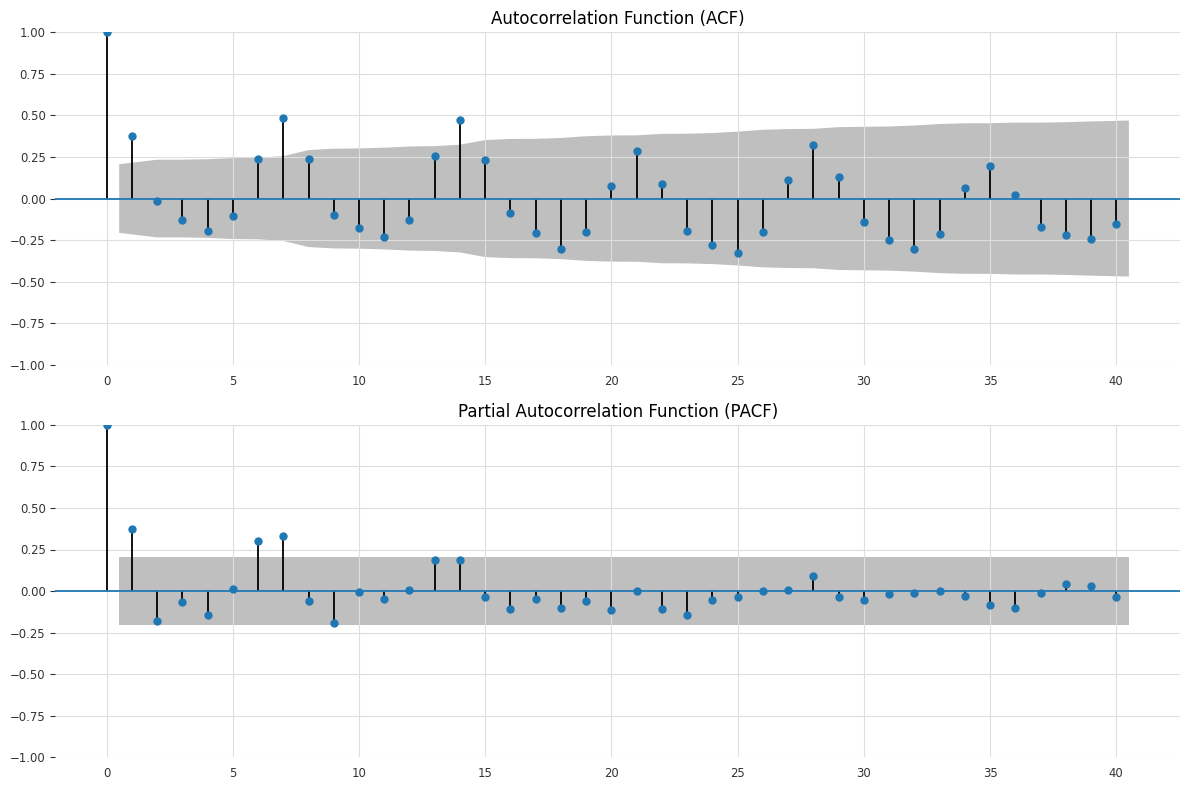

ADF Statistic: -2.150
p-value: 0.225
Critical Values:
   1%: -3.513
   5%: -2.897
   10%: -2.586


In [41]:
def decompose_time_series(df, period=30):
    print(f"\n=== TIME SERIES DECOMPOSITION ===")
    
    # Define blue colors
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue = '#aec7e8'  # Lighter blue for variety
    
    df = df.set_index('date')['unit_sales']
    
    # Resample to daily frequency
    df = df.resample('D').mean().fillna(method='ffill')
    
    # Decompose time series
    decomposition = seasonal_decompose(df, period=period, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Observed component
    axes[0].plot(decomposition.observed, color=blue_color, linewidth=1.5)
    axes[0].set_title('Observed')
    
    # Trend component
    axes[1].plot(decomposition.trend, color=blue_color, linewidth=1.5)
    axes[1].set_title('Trend')
    
    # Seasonal component
    axes[2].plot(decomposition.seasonal, color=blue_color, linewidth=1.5)
    axes[2].set_title('Seasonal')
    
    # Residual component
    axes[3].plot(decomposition.resid, color=blue_color, linewidth=1.5)
    axes[3].set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # ACF and PACF plots for ARIMA parameter selection
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF plot with blue color
    plot_acf(df.dropna(), ax=axes[0], lags=40, color=blue_color)
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # PACF plot with blue color
    plot_pacf(df.dropna(), ax=axes[1], lags=40, color=blue_color)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity test
    result = adfuller(df.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

decompose_time_series(df_train)

Stationarity Conclusion = NON_Stationary
 - The p-value (0.225) is greater than 0.05 
 - The ADF statistic (-2.150) is less negative than all critical values
 - The time series is non-stationary

The Series has:
 - Trend component (upward/downward drift)
 - Possibly seasonality  
 - Changing variance over time
 - Non-constant mean

ACF:
 - Shows slow, gradual decay toward zero
 - Significant correlations persist across many lags

PACF:
 - Shows sharp cutoff after one or a few lags
 - Significant spike at lag 1, then quickly drops to near zero
 - This suggests an autoregressive process


### 4. ARIMA Modeling

In [42]:
# Group by date and aggregate sales for each day
series = df_train.groupby('date')['unit_sales'].sum().reset_index()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').sort_index()
series = series['unit_sales']

In [43]:
# Train-Test-Split
split_date = '2014-03-01'

train = series[series.index < split_date]
test = series[series.index >= split_date]

In [44]:
# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(train, order=(1,1,1))

# Fit the ARIMA model on the training data
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_forecast.index = test.index  # align forecast with test dates

                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -629.192
Date:                Wed, 27 Aug 2025   AIC                           1264.383
Time:                        15:31:51   BIC                           1270.565
Sample:                    01-01-2014   HQIC                          1266.791
                         - 02-28-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7291      0.120     -6.087      0.000      -0.964      -0.494
ma.L1          1.0000      0.102      9.822      0.000       0.800       1.200
sigma2      1.491e+08   6.83e-10   2.18e+17      0.0

/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/VS Code Workspace/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


R2 score: -0.39
Mean Absolute Error: 7959.40
AIC: 1264.38


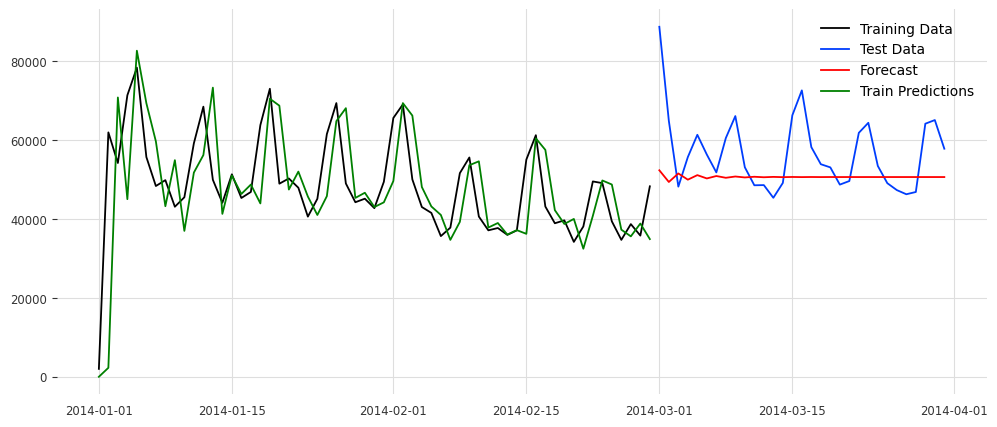

(date
 2014-03-01    52340.693909
 2014-03-02    49377.042627
 2014-03-03    51537.901259
 2014-03-04    49962.375131
 2014-03-05    51111.123385
 2014-03-06    50273.547589
 2014-03-07    50884.241195
 2014-03-08    50438.972024
 2014-03-09    50763.626864
 2014-03-10    50526.914394
 2014-03-11    50699.506287
 2014-03-12    50573.666016
 2014-03-13    50665.418725
 2014-03-14    50598.519952
 2014-03-15    50647.297213
 2014-03-16    50611.732717
 2014-03-17    50637.663517
 2014-03-18    50618.756841
 2014-03-19    50632.542084
 2014-03-20    50622.490982
 2014-03-21    50629.819446
 2014-03-22    50624.476113
 2014-03-23    50628.372046
 2014-03-24    50625.531442
 2014-03-25    50627.602584
 2014-03-26    50626.092472
 2014-03-27    50627.193526
 2014-03-28    50626.390725
 2014-03-29    50626.976064
 2014-03-30    50626.549281
 2014-03-31    50626.860457
 Name: predicted_mean, dtype: float64,
 -0.3880567310575589,
 7959.395422024661)

In [45]:
def model_evaluation(fit_result, train, test, exog=None):
    '''
    Evaluates a fitted ARIMA/SARIMAX model against a given test set
    '''
    # In-sample predictions
    train_predictions = fit_result.fittedvalues

    # Forecast future values
    if exog is not None:
        forecast = fit_result.get_forecast(steps=len(test), exog=test[exog])
        test_predictions = forecast.predicted_mean
    else:
        test_predictions = fit_result.forecast(steps=len(test))
    
    # Align forecast index with test index
    test_predictions.index = test.index

    # Evaluation metrics
    mae = mean_absolute_error(test, test_predictions)
    r2 = r2_score(test, test_predictions)

    print(f'R2 score: {r2:1.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'AIC: {fit_result.aic:.2f}')

    # Plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(train, label='Training Data')
    ax.plot(test, label='Test Data')
    ax.plot(test_predictions, label='Forecast', color='red')
    ax.plot(train_predictions, label='Train Predictions', color='green')
    plt.legend()
    plt.show()

    return test_predictions, r2, mae

model_evaluation(arima_model_fit, train, test, exog=None)

 - ARIMA models require a sufficient number of data points to identify and estimate patterns (trends, seasonality). 

 - 90 points is the absolute lower limit and often not meaningful, like in our case. 
 
 - Also the R2-Score of -0,39 shows a poor performance. 